# Analyse processed migration data

In [21]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import warnings

## Import data

In [38]:
df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")
df_all["value"].fillna(1.0, inplace=True) # at least 1 person per timeframe for multiplicative seasonal decomposition

with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

series = {c: df_all[df_all.country==c].value for c in countries}
series["NL"]

date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

## Define functions for plotting and analysis

Time series plot

In [40]:
def plot_timeseries(ser, countries, n_cols=3, title=None):
    n_rows = math.ceil(len(countries) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                country = countries[i * n_cols + j]
                ts = ser[country]
                ax = axs[i, j]

                ts.plot(ax=ax)
                ax.set_title(country)
            except ValueError:
                pass

    if title is not None:
        title = fig.suptitle(fontsize=32)
    plt.tight_layout()

    return fig


ACF/PACF

In [73]:
def plot_autocorrelation(ser, countries, type="acf", n_cols=3, n_lags=24, title=None):

    n_rows = math.ceil(len(countries) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    fig.set_facecolor("white")

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                ax = axs[i, j]
                country = countries[i * n_cols + j]

                ts = ser[country]
                if type == "acf":
                    smg.tsaplots.plot_acf(ts, ax=ax, lags=n_lags)
                elif type == "pacf":
                    smg.tsaplots.plot_pacf(ts, ax=ax, lags=n_lags, method="ywm")
                ax.set_title(country)
            except np.linalg.LinAlgError:
                warnings.warn("LinAlgError produced for country " + country)
                pass

    if title is not None:
        fig.suptitle(title, fontsize=32)
    plt.tight_layout()
    return fig



ADF test

In [53]:
def test_adf(ser, countries, n_lags=None):

    adf_values, p_values = [], []

    for c in countries:
        ts = ser[c]
        test_results = sm.tsa.stattools.adfuller(ts, maxlag=n_lags)

        adf_values.append(test_results[0])
        p_values.append(test_results[1])

    df_results = pd.DataFrame({"country": countries, "adf": adf_values, "p": p_values})

    return df_results


## Transformation and analysis

Plot raw time series

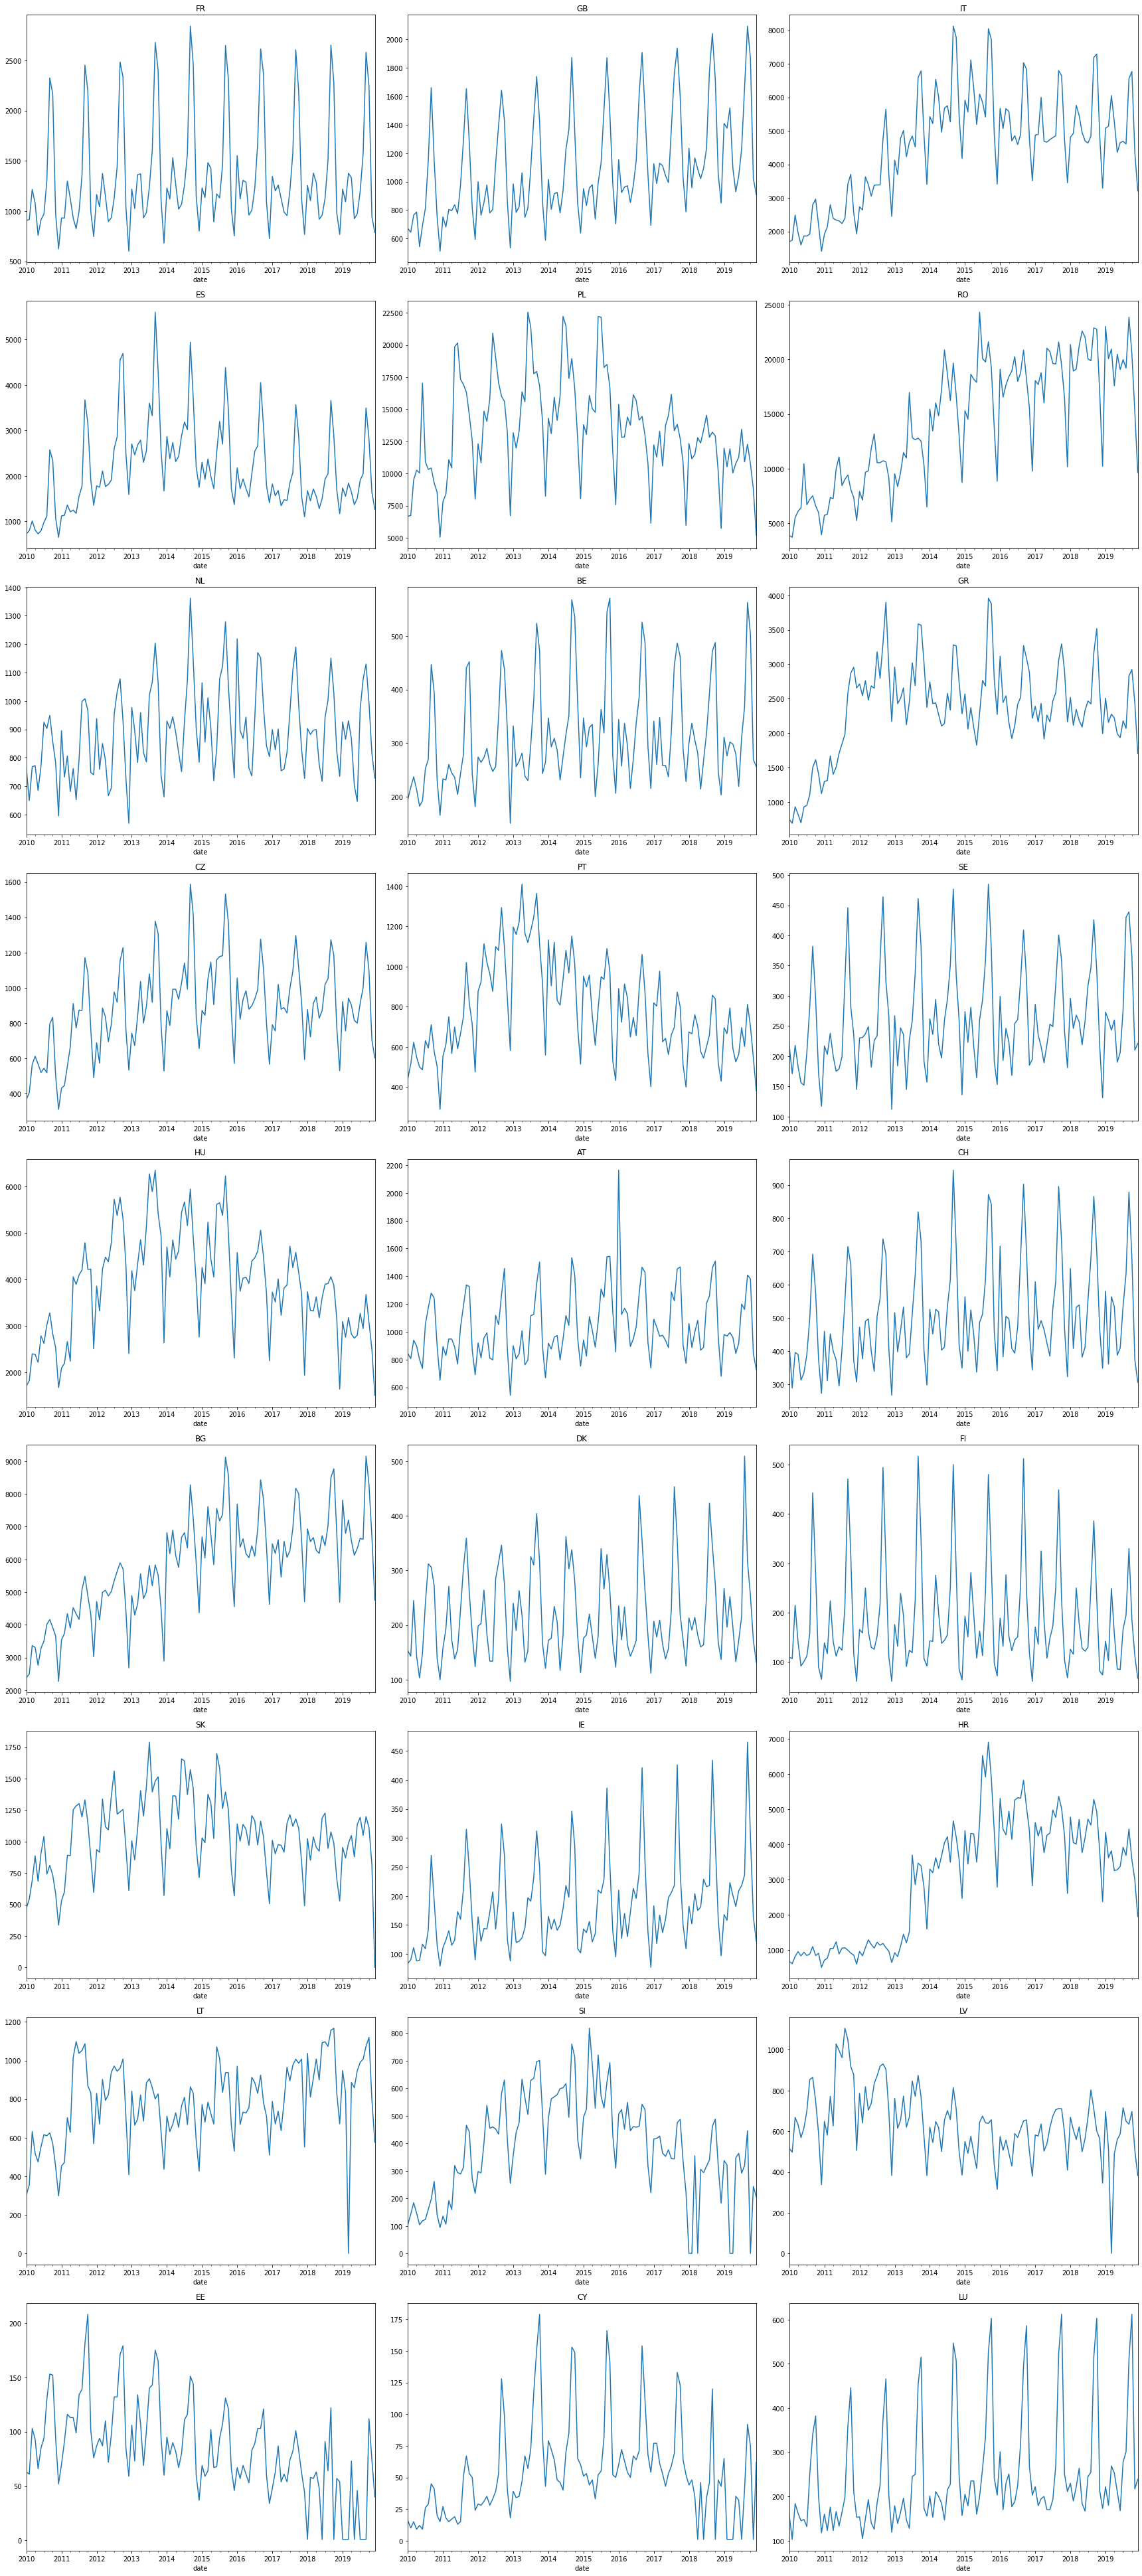

In [44]:
plot_timeseries(series, countries)
plt.show()

Raw ACF

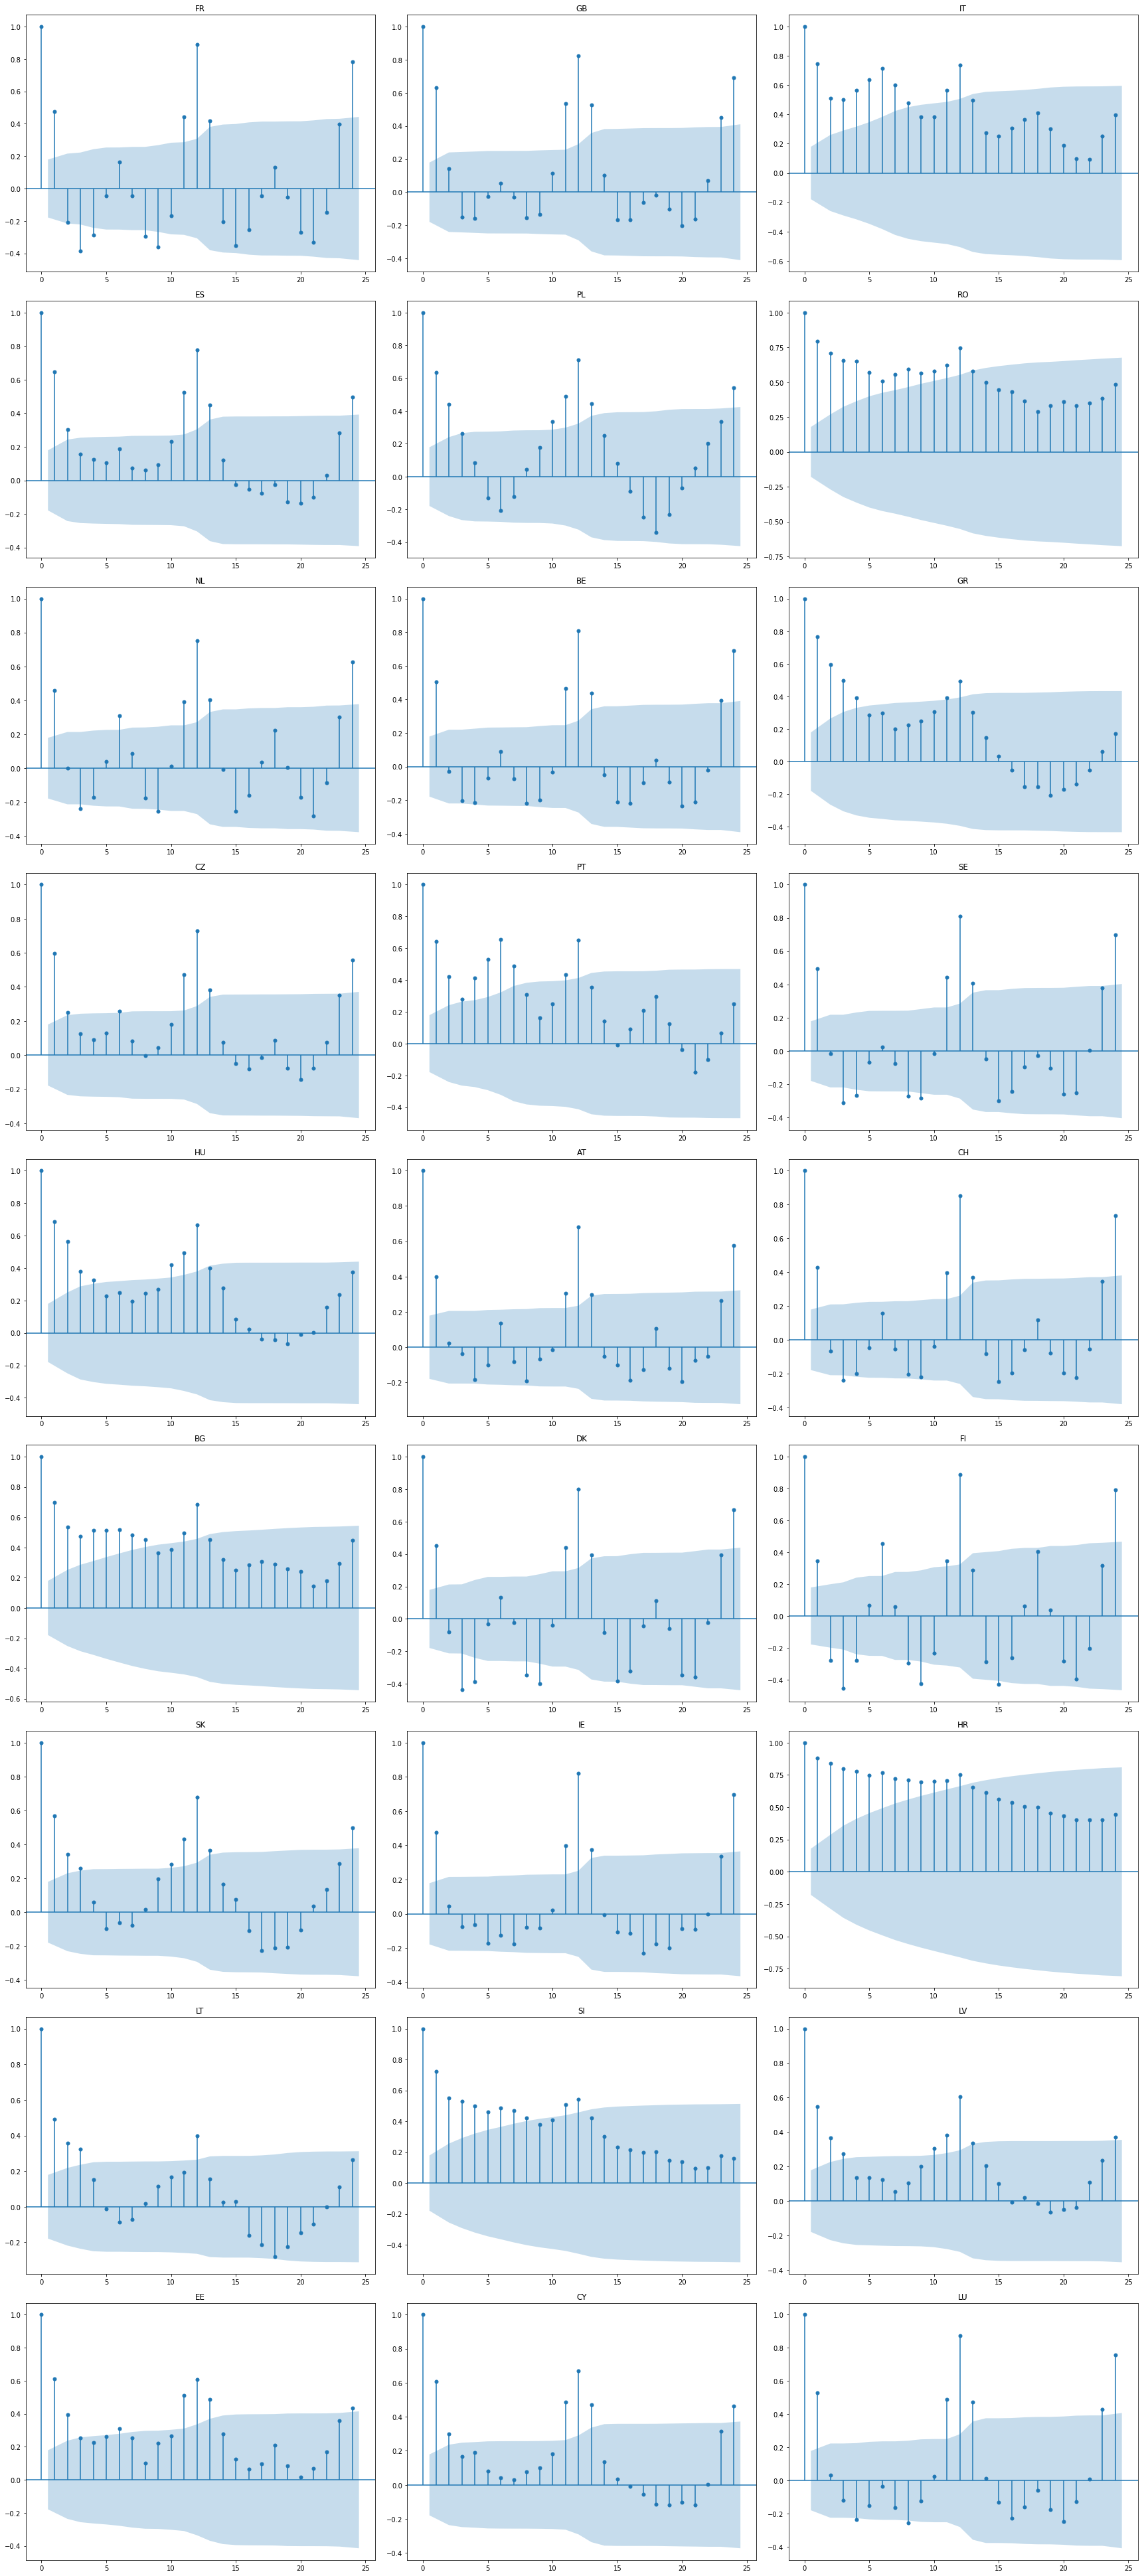

In [49]:
plot_autocorrelation(series, countries)
plt.show()

Transform

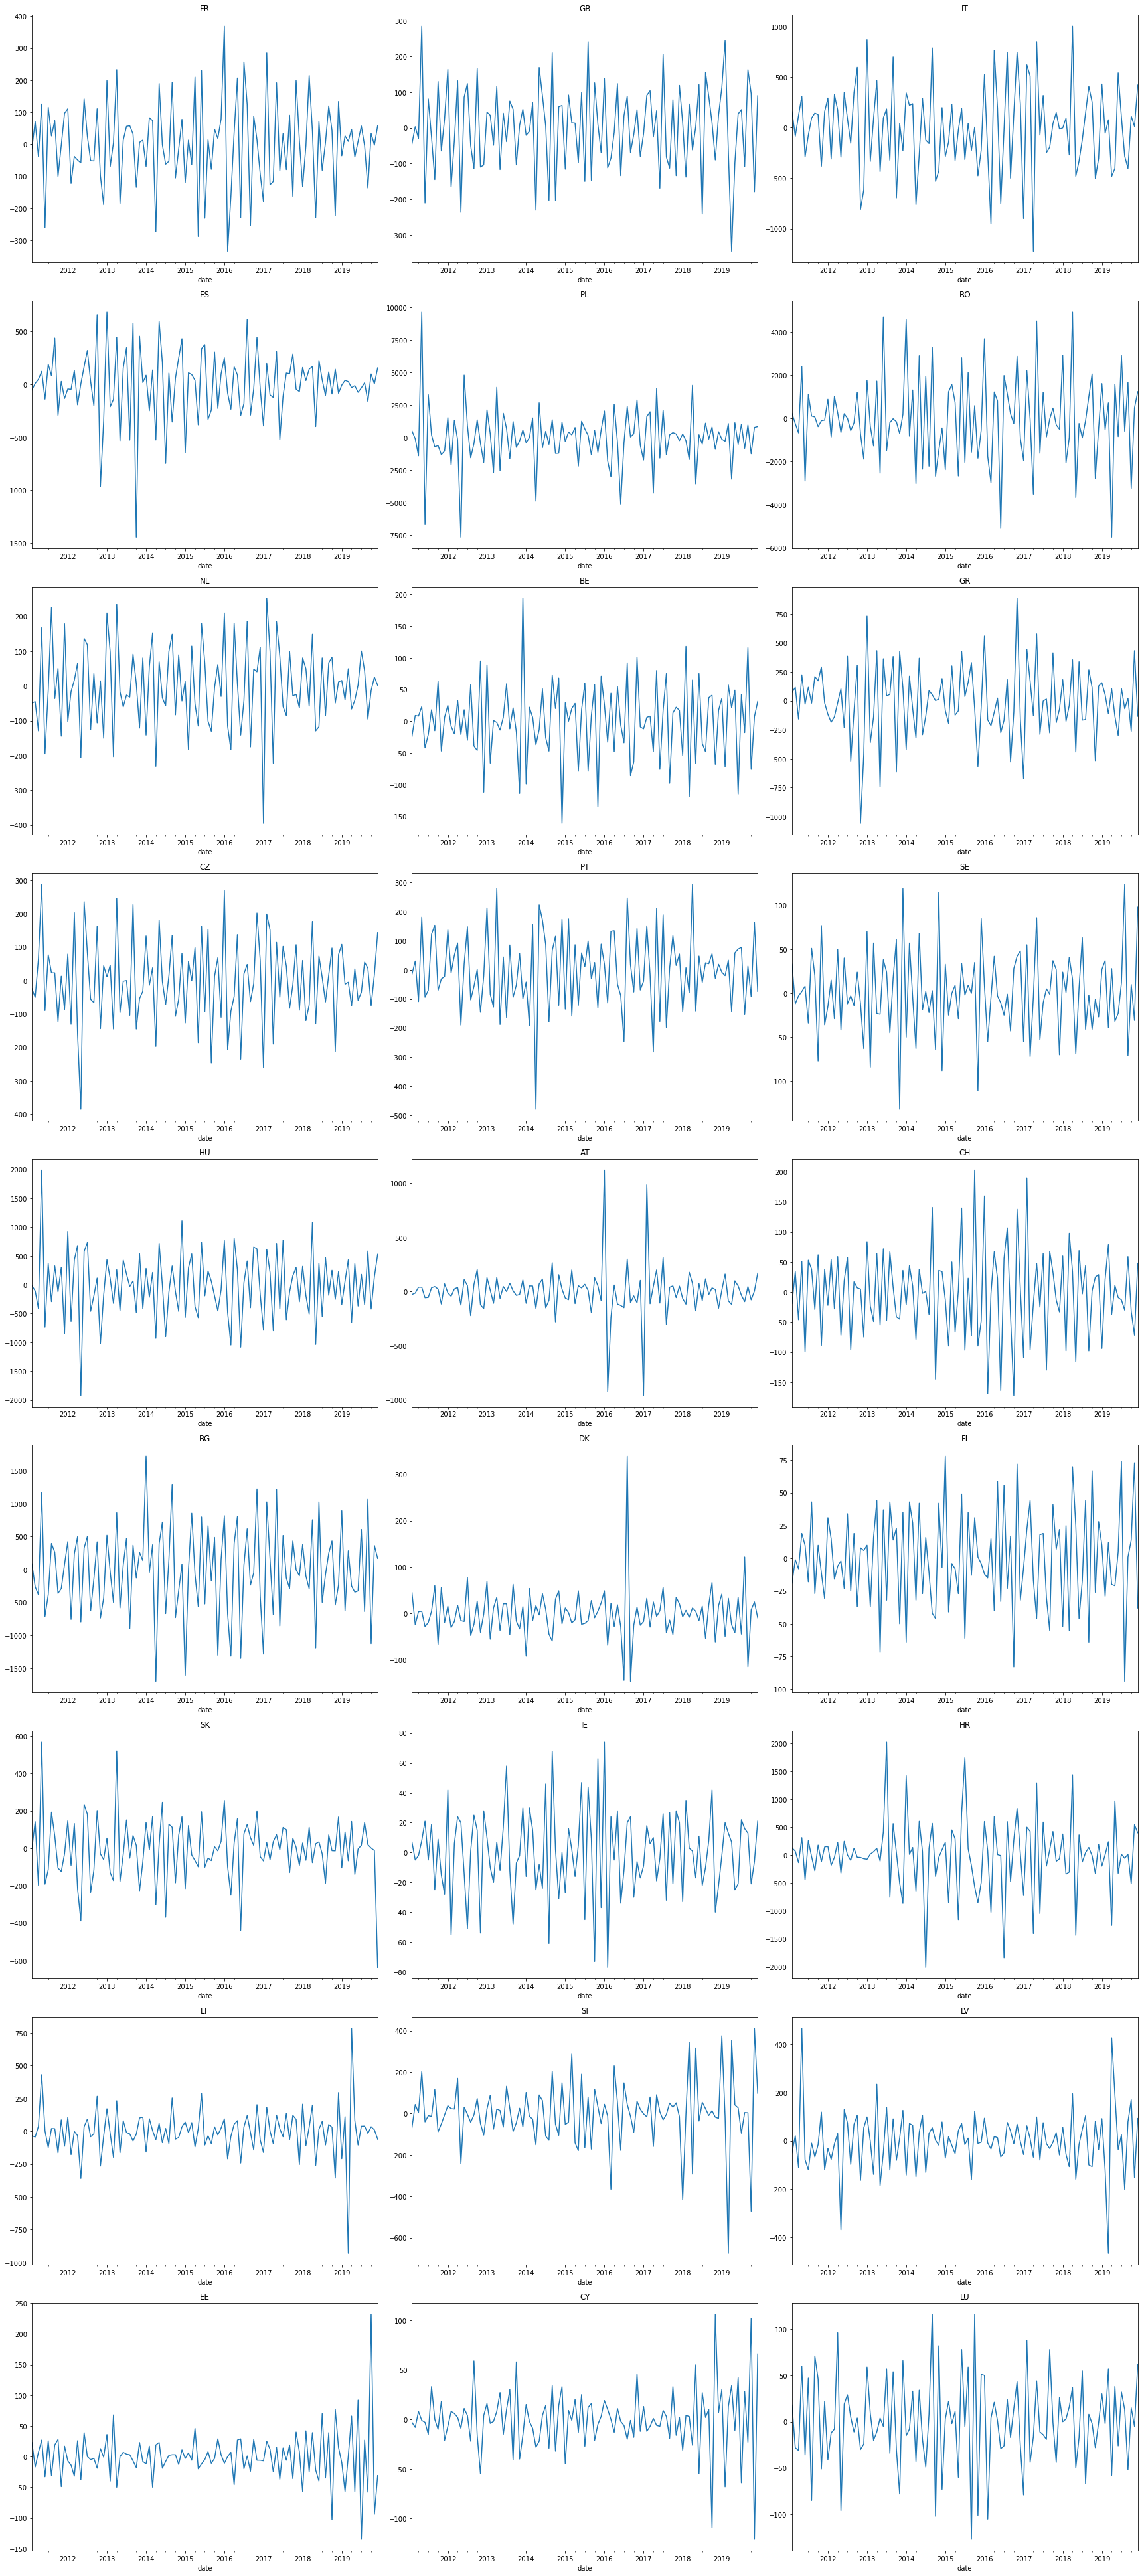

In [118]:
# series_resampled = {c: series[c].resample("3M").mean() for c in countries}

series_transformed = {c: (series[c].diff() - series[c].diff().shift(12))[13:] for c in countries}
plot_timeseries(series_transformed, countries)
plt.show()

ACF for transformation

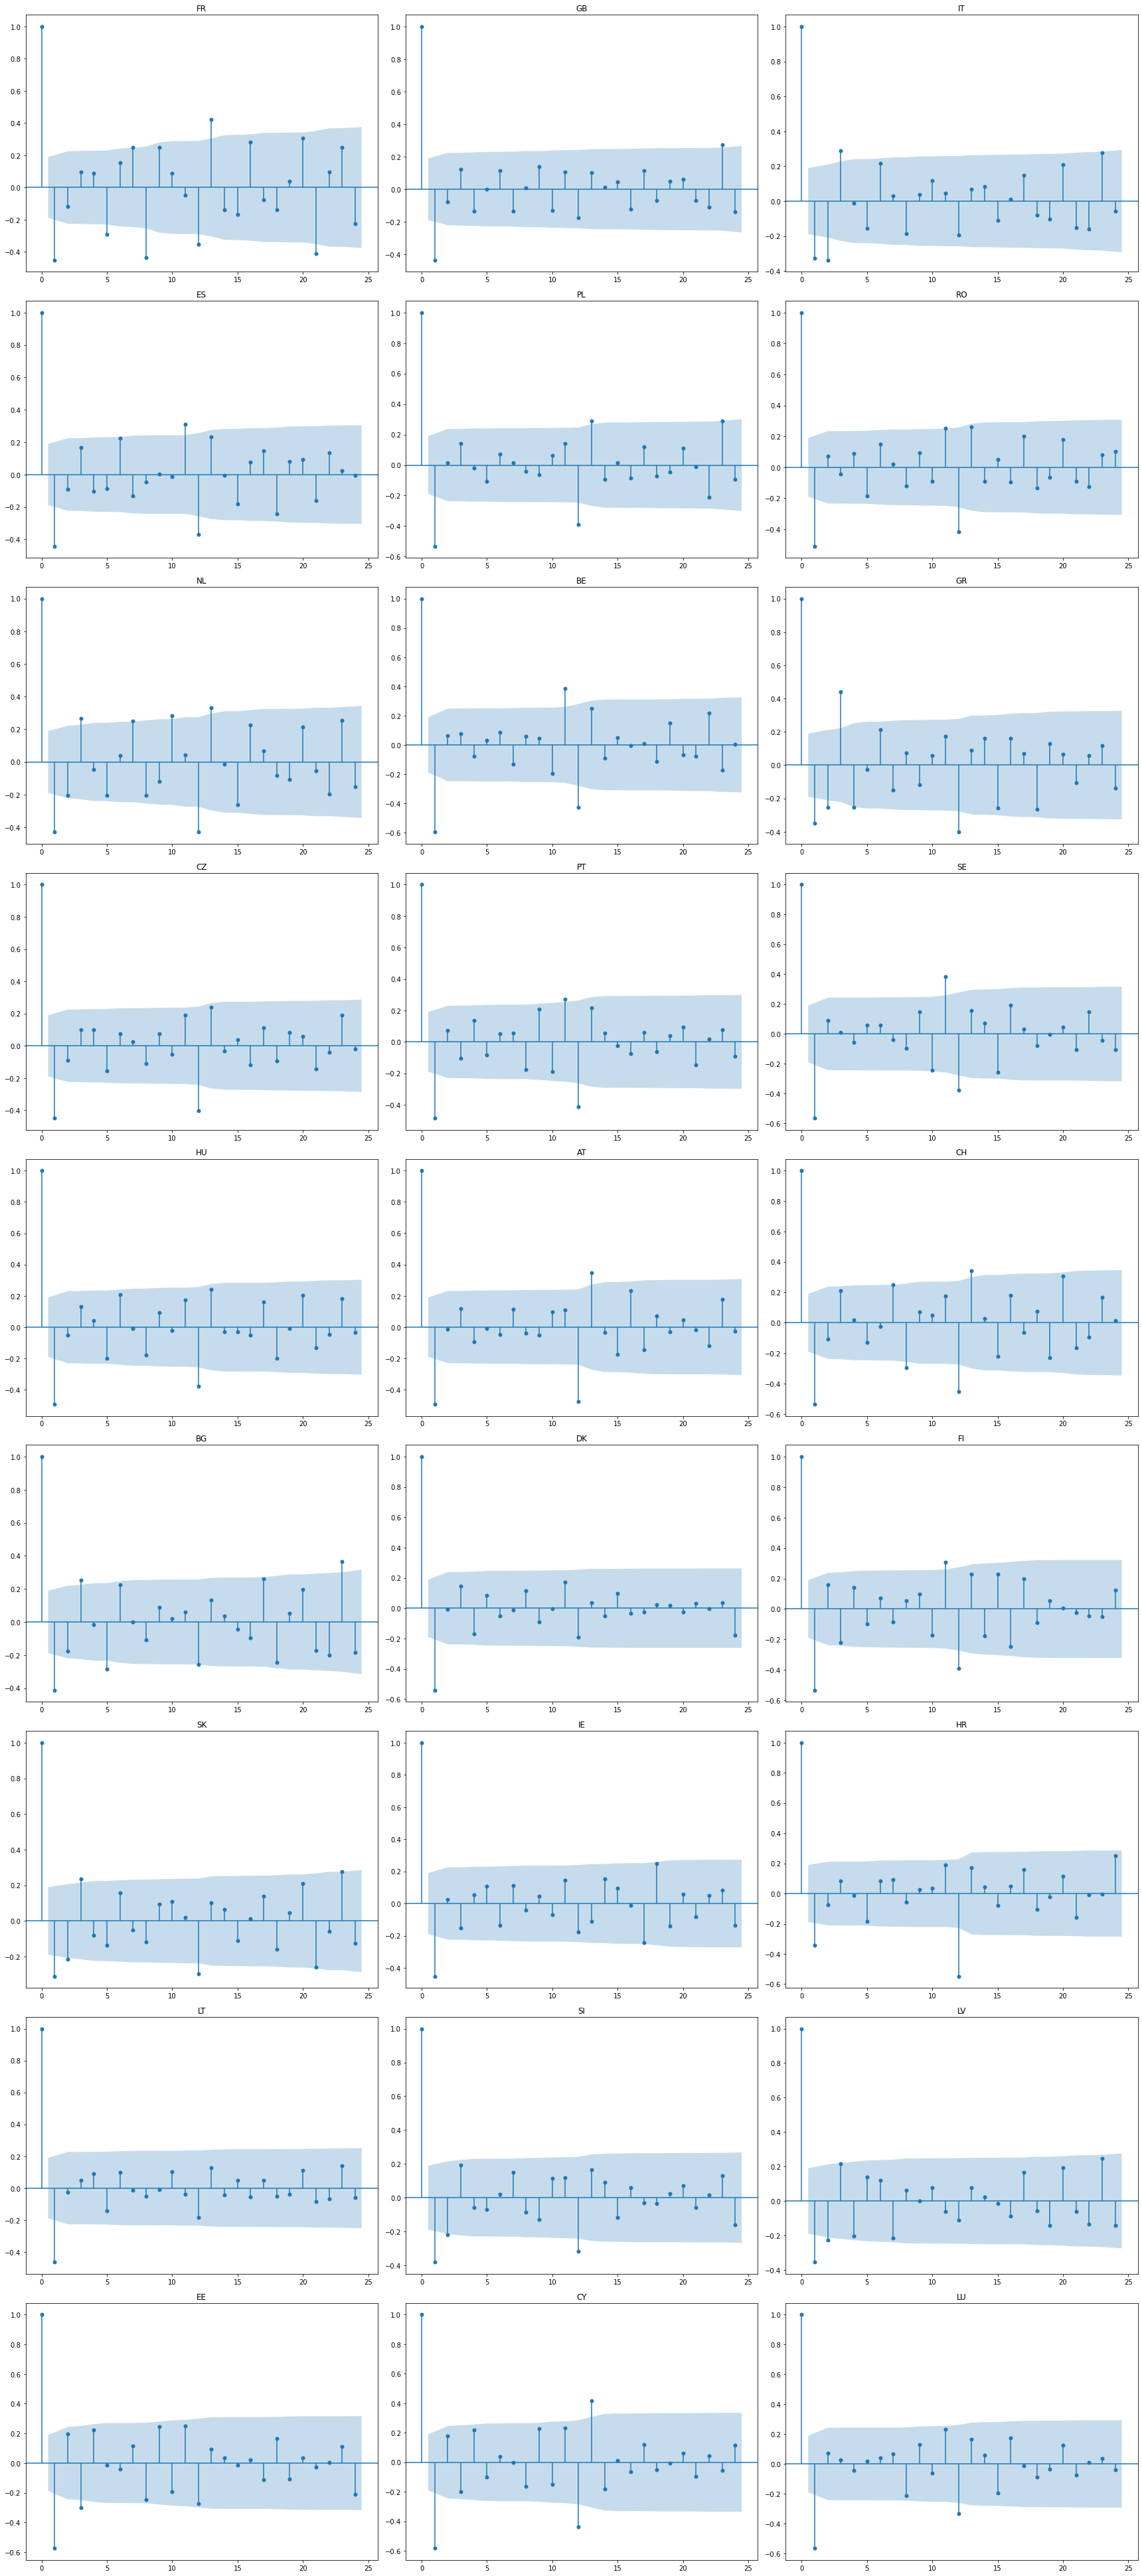

In [119]:
plot_autocorrelation(series_transformed, countries, type="acf")
plt.show()

PACF

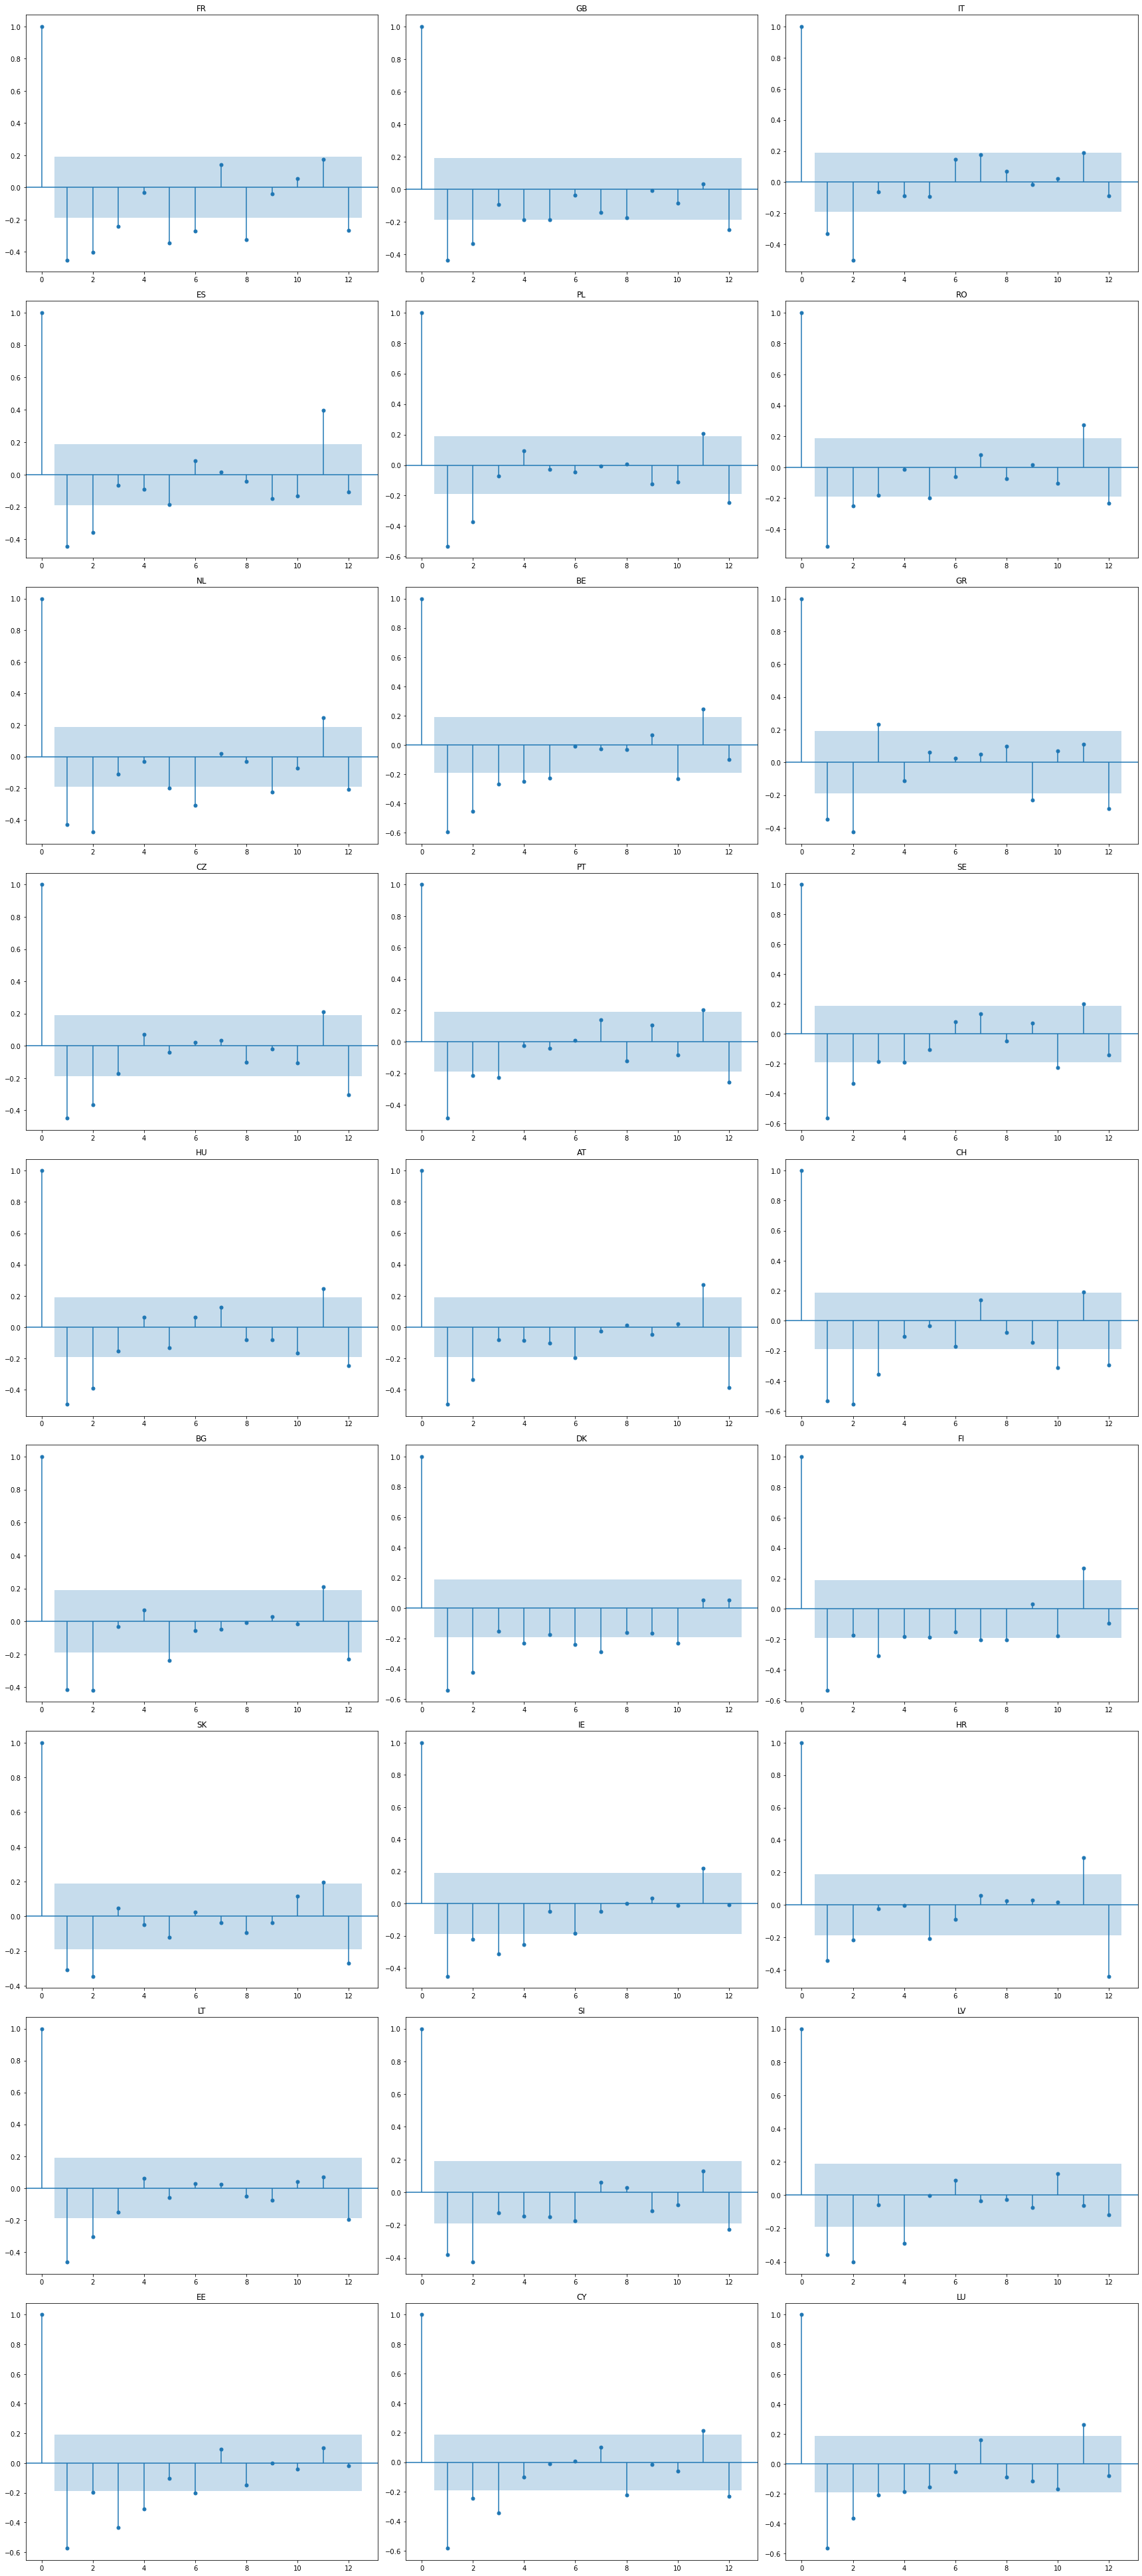

In [120]:
plot_autocorrelation(series_transformed, countries, type="pacf", n_lags=12)
plt.show()

In [121]:
test_adf(series_transformed, countries)

,country,adf,p
0,FR,-4.322783,4.055434e-04
1,GB,-4.722113,7.646147e-05
2,IT,-14.332457,1.094027e-26
3,ES,-2.218416,1.996295e-01
4,PL,-4.196643,6.675737e-04
5,RO,-3.192245,2.043797e-02
6,NL,-3.952347,1.681652e-03
7,BE,-3.235210,1.803492e-02
8,GR,-4.187908,6.906512e-04
9,CZ,-4.601376,1.284173e-04


## Try decomposition

In [122]:
residuals = {}

for c in countries:

    stl = sm.tsa.STL(
        series[c],
        period=12,
    )
    res = stl.fit()

    residuals[c]=res


In [123]:
def plot_decomp(res, title=None):

    fig = res.plot()
    fig.set_figwidth(6)
    fig.set_figheight(8)
    fig.set_dpi(100)
    plt.suptitle(title)
    fig.set_facecolor("white")

    return fig


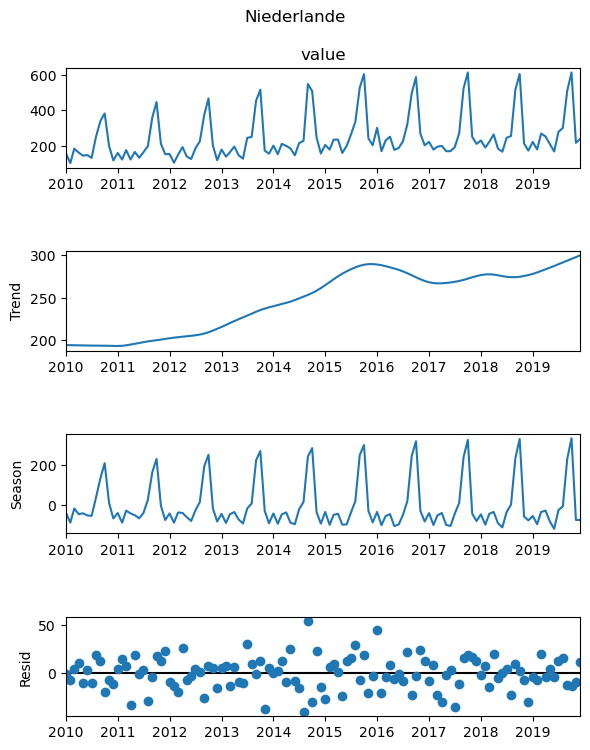

In [124]:
plot_decomp(res, "Niederlande")
plt.show()